In [47]:
import pandas as pd
import json

from matplotlib import pyplot as plt
from collections.abc import Mapping
from typing import Any, Literal
from itertools import product
from pathlib import Path

## Plot Convergence:

In [61]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [67]:
PSO = parse_results("./results/result_ParticleSwarm_ST_1_e0b2c0e4-07c8-48e1-bfb2-3e4922540944.jsonl")
PH = parse_results("./results/result_PolyHoot_TF_1_c5e1a8ba-b3e4-4465-963a-30214157b350.jsonl")
GS = parse_results("./results/result_GridSearch_ST_1_extensive.jsonl")
B = parse_results("./results/result_Bayesian_ST_8_bdf17783-8c8e-456c-9c44-f7a34e66af52.jsonl")

In [69]:
import matplotlib.pyplot as plt

def plot_convergence(
    dfs,
    column,
    labels=None,
    figsize=(8, 5),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    colors=None,
    linestyles=None,
    linewidths=None
):
    """
    Plot multiple convergence lines, each from its own DataFrame.

    Parameters
    ----------
    dfs : list of pandas.DataFrame
        List of DataFrames containing the data, each indexed by iteration and sharing the same columns.
    column : str
        Name of the column to plot from each DataFrame.
    labels : list of str, optional
        Labels for the legend corresponding to each DataFrame. Defaults to generic names.
    figsize : tuple, optional
        Figure size in inches (width, height).
    title_fontsize : int, optional
        Font size for the plot title.
    label_fontsize : int, optional
        Font size for axis labels and legend text.
    tick_fontsize : int, optional
        Font size for axis ticks.
    dpi : int, optional
        Resolution of the figure.
    colors : list of str, optional
        List of colors for each line.
    linestyles : list of str, optional
        List of linestyles for each line.
    linewidths : list of float, optional
        List of line widths for each line.
    """
    # Configure global style
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # Validate inputs
    n = len(dfs)
    if n == 0:
        raise ValueError("Please provide at least one DataFrame to plot.")
    if n > 4:
        raise ValueError(f"This function supports up to 4 lines; you passed {n} DataFrames.")

    # Set defaults
    if labels is None:
        labels = [f"Line {i+1}" for i in range(n)]
    if colors is None:
        cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        colors = cycle[:n]
    if linestyles is None:
        linestyles = ["-"] * n
    if linewidths is None:
        linewidths = [1.5] * n

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    for df_i, lbl, c, ls, lw in zip(dfs, labels, colors, linestyles, linewidths):
        ax.plot(
            df_i.index,
            df_i[column],
            label=lbl,
            color=c,
            linestyle=ls,
            linewidth=lw
        )

    ax.set_title("Convergence", pad=10)
    ax.set_xlabel("Iterations", fontsize=label_fontsize)
    ax.set_ylabel(column, fontsize=label_fontsize)
    ax.legend(fontsize=label_fontsize)
    ax.grid(True)

    plt.tight_layout()
    plt.show()


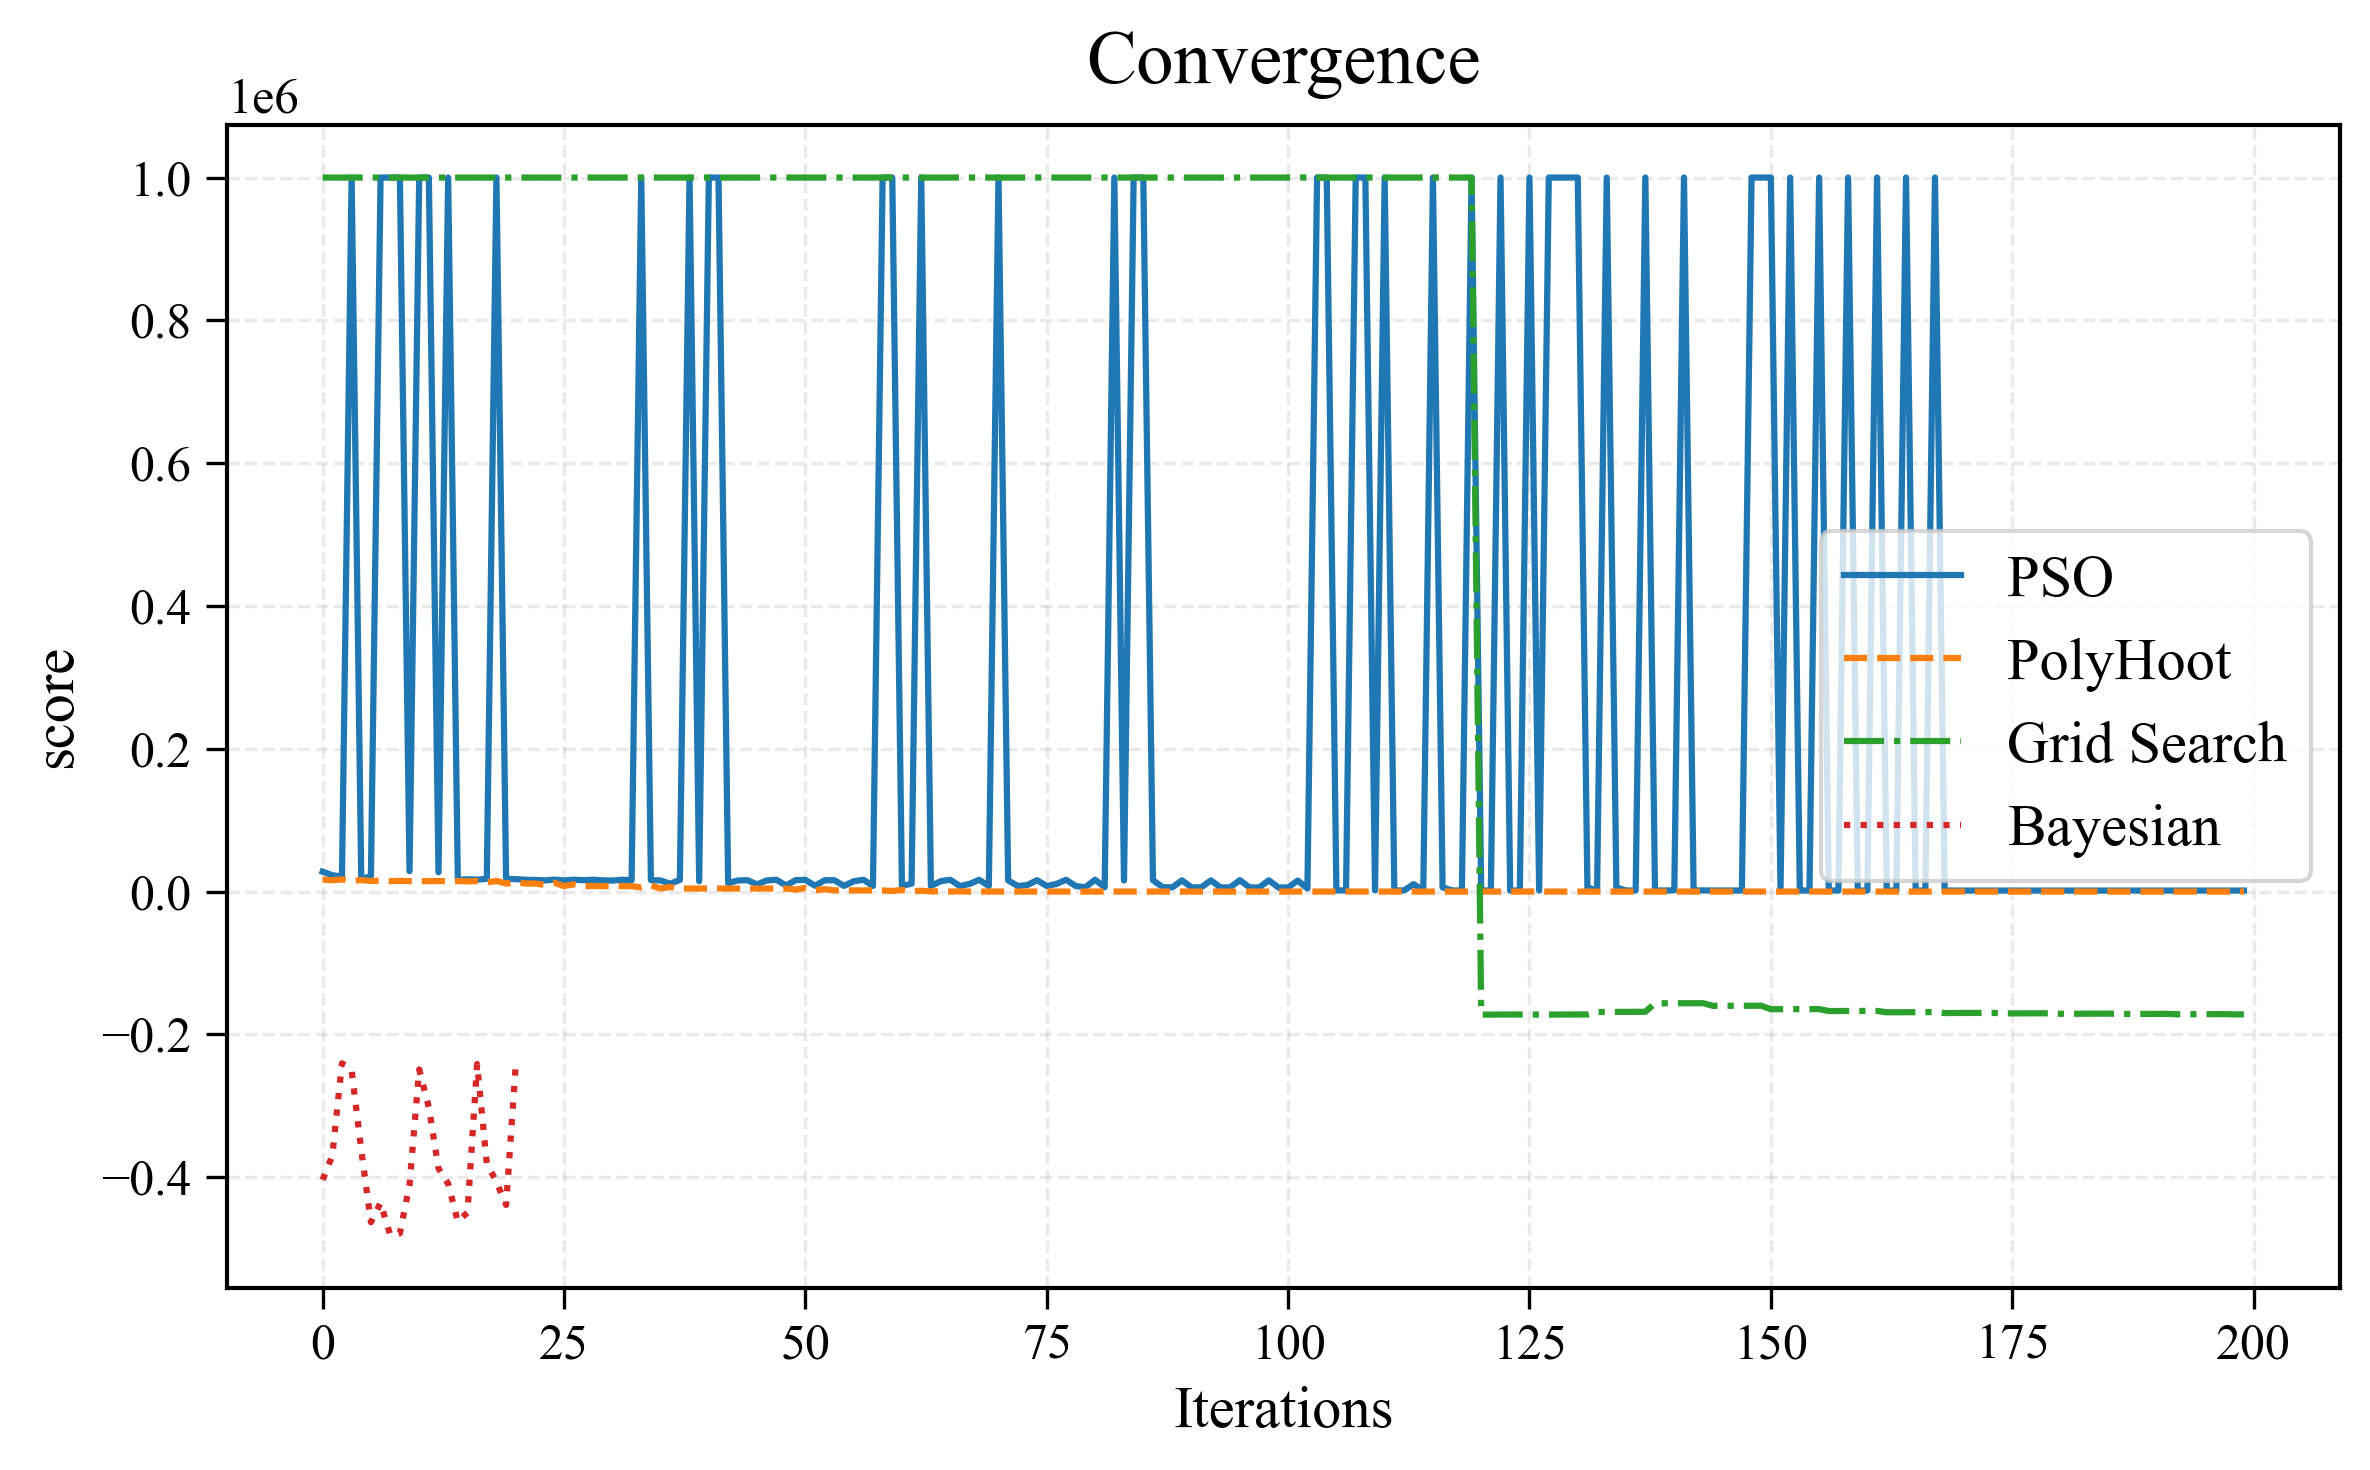

In [74]:
n = 200

GS = GS.head(n)
PSO = PSO.head(n)
PH = PH.head(n)
B = B.head(n)

plot_convergence(
    dfs=[PSO, PH, GS, B],
    column='score',
    labels=['PSO', 'PolyHoot', 'Grid Search', 'Bayesian'],
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
    linestyles=['-', '--', '-.', ':']
)